In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from datetime import timedelta, date

import string
from itertools import product

#Translate
from googletrans import Translator
translator = Translator()

#NLTK
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Models
import xgboost
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV,RandomizedSearchCV
from sklearn.metrics import mean_squared_error

pd.set_option('display.max_columns', None)
SEED=101

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\miguel.almas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Import Data

In [2]:
df_sales_train = pd.read_csv('.\sales_train\sales_train_v2.csv')
df_sales_test = pd.read_csv('.\\test\\test.csv')
df_sample_submission = pd.read_csv('.\\sample_submission\\sample_submission.csv')
#If original, rusian files are desired, uncomment below
#df_shops = pd.read_csv('shops.csv')
#df_items_2 = pd.read_csv('items.csv')
#df_item_categories = pd.read_csv('item_categories.csv')
#Importing translated files
df_shops = pd.read_csv('.\\data_files\\shops_translated.csv')
df_items = pd.read_csv('.\\data_files\\items_translated.csv')
df_item_categories = pd.read_csv('.\\data_files\\item_categories_translated.csv')

# Initial Data Exploration

In [3]:
df_sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [4]:
df_sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

In [5]:
df_sales_train.head(2)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0
1,03.01.2013,0,25,2552,899.0,1.0


In [6]:
df_sales_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214200 entries, 0 to 214199
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype
---  ------   --------------   -----
 0   ID       214200 non-null  int64
 1   shop_id  214200 non-null  int64
 2   item_id  214200 non-null  int64
dtypes: int64(3)
memory usage: 4.9 MB


In [7]:
df_sales_test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [8]:
df_shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   shop_id               60 non-null     int64 
 1   shop_name_translated  60 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [9]:
df_shops.head(2)

,shop_id,shop_name_translated
0,0,"Yakutsk Ordzhonikidze, 56 francs"
1,1,"Yakutsk TC ""Central"" franc"


In [10]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   item_id               22170 non-null  int64 
 1   item_name_translated  22170 non-null  object
 2   item_category_id      22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [11]:
df_item_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   item_category_id               84 non-null     int64 
 1   item_category_name_translated  84 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [12]:
df_item_categories.head(2)

,item_category_id,item_category_name_translated
0,0,PC - Headsets / Headphones
1,1,Accessories - PS2


Our target variable is __item_cnt_day__.

Data is normalized across several files, we'll need to merge if we are to try and extract interesting information from product name and categories.

Names are in cyrilic. This should be irrelevant to a model but it can be tricky if we are to try and visualize it or perform some text processing techniques. Having a readable format (for non russian readers) will be useful!

No explicit (NaN) exist in any of the datasets.

## Data Description

Data fields

ID - an Id that represents a (Shop, Item) tuple within the test set

shop_id - unique identifier of a shop

item_id - unique identifier of a product

item_category_id - unique identifier of item category

item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

item_price - current price of an item

date - date in format dd/mm/yyyy

date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

item_name - name of item

shop_name - name of shop

item_category_name - name of item category

__NOTE:__ True target values are clipped into [0,20] range.

# Train and Test Set Analysis

#### Shops in test that are not in train set

In [13]:
list_items_exclusive_test = np.setdiff1d(df_sales_test['item_id'].unique(),df_sales_train['item_id'].unique())
len(list_items_exclusive_test)

363

363 items of the test set are new!

In [14]:
df_common_item_shop = pd.merge(df_sales_test,df_sales_train,on=['shop_id','item_id'],how='inner')
print('There are {} pairs of shop/item that appear in both test and train sets.'.format(df_common_item_shop['ID'].nunique()))

There are 111404 pairs of shop/item that appear in both test and train sets.


In [15]:
df_item_shop_pairs_no_data = df_sales_test[~(df_sales_test['item_id'].isin(df_sales_train['item_id']))]
print('There are {} pairs of shop/item corresponding to items that do not exist in the train set.'.format(df_item_shop_pairs_no_data.shape[0]))

There are 15246 pairs of shop/item corresponding to items that do not exist in the train set.


In [16]:
print('There are {} items that appear in shops where they were not available in the training set.'.format(df_sales_test.shape[0] - df_common_item_shop['ID'].nunique() - df_item_shop_pairs_no_data.shape[0]))

There are 87550 items that appear in shops where they were not available in the training set.


This presents a challenge as a model trained on data for shop/id pairs of the train set can struggle to predict pairs it does not know or only partially knows (information about shop, not item or vice-versa).

We should probably divide this problem in 3, one where we predict known cases of shop/item pairs, cases where we know the item but not the item/shop combination and finally a case where we do not know the item itself.

# Translate Russian to English

Datasets were translated from Russian to English using the code below. To reduce time to run notebook,they were stored in new csv files which are then imported directly at the top of the notebook.

In [17]:
#Translate
#df_shops['shop_name'] = df_shops['shop_name'].apply(translator.translate, src='ru', dest='en').apply(getattr, args=('text',))
#df_items['item_name'] = df_items['item_name'].apply(translator.translate, src='ru', dest='en').apply(getattr, args=('text',))
#df_item_categories['item_category_name'] = df_item_categories['item_category_name'].apply(translator.translate, src='ru', dest='en').apply(getattr, args=('text',))
#Store to csv
#df_shops.to_csv('.\\data_files\\shops_translated.csv',index=False)
#df_items.to_csv('.\\data_files\\items_translated.csv',index=False)
#df_item_categories.to_csv('.\\data_files\\item_categories_translated.csv',index=False)

# Data Pre-Processing

## Test Set

This datasets contains the ID of shops and products on the month of November 2015. But no date information. This could be useful to use information of month and year for the model.

Let's add a month and year information.

In [18]:
df_sales_test['year'] = 2015
df_sales_test['month'] = 11

## Merge Datasets (Train/Test)

Let's temporarily join training and test sets for pre-processing

In [19]:
df_sales_train.head(1)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.0,1.0


In [20]:
df_sales_test.head(1)

,ID,shop_id,item_id,year,month
0,0,5,5037,2015,11


In [21]:
#Create feature to facilitate resplitting by train and test set after data preprocessing
df_sales_train['set'] = 'train'
df_sales_test['set'] = 'test'
#Add date_block_num to test set
df_sales_test['date_block_num'] = df_sales_train['date_block_num'].max() + 1
#Merge train and test set
df_sales = pd.concat((df_sales_train,df_sales_test),axis=0)

## Date Feature

Let's extract features from the date field.

In [22]:
#Turn date to datetime
df_sales['date'] = pd.to_datetime(df_sales['date'],format='%d.%m.%Y')
#Extract date features
df_sales['year'] = df_sales['date'].dt.year
df_sales['month'] = df_sales['date'].dt.month
df_sales['day'] = df_sales['date'].dt.day
df_sales['day_of_week'] = df_sales['date'].dt.day_name()

## Item Category

In [23]:
df_item_categories.sample(10)

,item_category_id,item_category_name_translated
62,62,"Gifts - Gadgets, robots, sports"
0,0,PC - Headsets / Headphones
32,32,"Payment cards (Movies, Music, Games)"
13,13,Game Consoles - PSP
77,77,Programs - Teaching
74,74,Programs - MAC (Number)
58,58,Music - Vinyl
79,79,Office
8,8,Tickets (figure)
42,42,"Books - Artbook, encyclopedia"


The categories seem to include subcategories after the -. Let's extract them!

In [24]:
#Split by the -
tmp = df_item_categories['item_category_name_translated'].str.split(' - ')
#Get category and subcategory
df_item_categories['item_category'] = tmp.apply(lambda x: x[0])
df_item_categories['item_subcategory'] = tmp.apply(lambda x: x[1] if len(x) > 1 else 'None')
del tmp

df_item_categories = df_item_categories.drop('item_category_name_translated',axis=1)

In [25]:
list(df_item_categories['item_category'].unique())

['PC',
 'Accessories',
 'Tickets (figure)',
 'Delivery of goods',
 'Game Consoles',
 'Games',
 'Android games',
 'MAC Games',
 'PC Games',
 'Payment cards (Movies, Music, Games)',
 'Payment cards',
 'Payment Cards',
 'Cinema',
 'Books',
 'Книги',
 'Music',
 'Gifts',
 'Programs',
 'Office',
 'Official',
 'Clean carriers (spire)',
 'Clean media (piece)',
 'Elements of a food']

### Payment Cards

In [26]:
filt = df_item_categories['item_category'].str.lower().str.contains('payment')
df_item_categories[filt]

,item_category_id,item_category,item_subcategory
32,32,"Payment cards (Movies, Music, Games)",None
33,33,Payment cards,Live!
34,34,Payment cards,Live! (Numeral)
35,35,Payment cards,PSN
36,36,Payment Cards,Windows (Digital)


Let's merge all these categories.

In [27]:
filt = df_item_categories['item_category'] == 'Payment cards (Movies, Music, Games)'
df_item_categories.loc[filt,'item_subcategory'] = 'Movies, Music, Games'
df_item_categories.loc[filt,'item_category'] = 'Payment cards'

filt = df_item_categories['item_category'] == 'Payment Cards'
df_item_categories.loc[filt,'item_category'] = 'Payment cards'

In [28]:
df_item_categories

,item_category_id,item_category,item_subcategory
0,0,PC,Headsets / Headphones
1,1,Accessories,PS2
2,2,Accessories,PS3
3,3,Accessories,PS4
4,4,Accessories,PSP
...,...,...,...
79,79,Office,None
80,80,Official,Tickets
81,81,Clean carriers (spire),None
82,82,Clean media (piece),None


### Games

In [29]:
filt = df_item_categories['item_category'].str.lower().str.contains('game')
df_item_categories[filt]

,item_category_id,item_category,item_subcategory
10,10,Game Consoles,PS2
11,11,Game Consoles,PS3
12,12,Game Consoles,PS4
13,13,Game Consoles,PSP
14,14,Game Consoles,PSVita
15,15,Game Consoles,XBOX 360
16,16,Game Consoles,XBOX ONE
17,17,Game Consoles,Other
18,18,Games,PS2
19,19,Games,PS3


Games should be concatenated into a single class, with subclas separating it further.

In [30]:
filt = df_item_categories['item_category'] == 'Android games'
df_item_categories.loc[filt,'item_subcategory'] = 'Android'
df_item_categories.loc[filt,'item_category'] = 'Games'

filt = df_item_categories['item_category'] == 'MAC Games'
df_item_categories.loc[filt,'item_subcategory'] = 'MAC'
df_item_categories.loc[filt,'item_category'] = 'Games'

filt = (df_item_categories['item_category'] == 'PC Games') & (df_item_categories['item_subcategory'] == 'Additional Edition')
df_item_categories.loc[filt,'item_subcategory'] = 'PC - Additional'
df_item_categories.loc[filt,'item_category'] = 'Games'

filt = (df_item_categories['item_category'] == 'PC Games') & (df_item_categories['item_subcategory'] == 'Collector\'s Edition')
df_item_categories.loc[filt,'item_subcategory'] = 'PC - Collector'
df_item_categories.loc[filt,'item_category'] = 'Games'

filt = (df_item_categories['item_category'] == 'PC Games') & (df_item_categories['item_subcategory'] == 'Standard Edition')
df_item_categories.loc[filt,'item_subcategory'] = 'PC - Standard'
df_item_categories.loc[filt,'item_category'] = 'Games'

filt = (df_item_categories['item_category'] == 'PC Games') & (df_item_categories['item_subcategory'] == 'Digit')
df_item_categories.loc[filt,'item_subcategory'] = 'PC'
df_item_categories.loc[filt,'item_category'] = 'Games'

In [31]:
filt = df_item_categories['item_category'].str.lower().str.contains('game')
df_item_categories[filt]

,item_category_id,item_category,item_subcategory
10,10,Game Consoles,PS2
11,11,Game Consoles,PS3
12,12,Game Consoles,PS4
13,13,Game Consoles,PSP
14,14,Game Consoles,PSVita
15,15,Game Consoles,XBOX 360
16,16,Game Consoles,XBOX ONE
17,17,Game Consoles,Other
18,18,Games,PS2
19,19,Games,PS3


## Items

In [32]:
df_items.sample(4)

,item_id,item_name_translated,item_category_id
5646,5646,PS3: Remote control black (CECHZR1R: SCEE),2
9583,9583,YOU ARE EXPECTED FOR AN ANNIVERSARY OF NIKANOV...,40
9111,9111,"BUCH1S, №12 December 2015 [Digital version]",54
11899,11899,IVAN TSAREVICH AND GRAY WOLF (region),40


In [33]:
#Unfortunately the translation left some russian words. So we'll remove english and russian stopwords.
russian_stopwords = stopwords.words("russian")
english_stopwords = stopwords.words("english")

#Remove punctuation and lowercase
df_items['item_name_translated_no_punct'] = df_items['item_name_translated'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
df_items['item_name_translated_no_punct'] = df_items['item_name_translated_no_punct'].str.lower()

#Initialize the Count Vectorizer
count_vectorizer = CountVectorizer(stop_words=russian_stopwords+english_stopwords, analyzer='word', 
                            ngram_range=(1, 1), max_features=None)

# Transforms the data into a bag of words
count_train = count_vectorizer.fit(df_items['item_name_translated_no_punct'])
bag_of_words = count_vectorizer.transform(df_items['item_name_translated_no_punct'])

#Store the words in a Series
series_item_word_freq = pd.Series(count_train.vocabulary_).sort_values(ascending=False)

# Print the first 10 features of the count_vec
print("Vocabulary size: {}".format(len(count_train.vocabulary_)))
series_item_word_freq.head(20)

Vocabulary size: 15139


ёрш            15138
ёлка           15137
янка           15136
яблоко         15135
эсхато         15134
эстрада        15133
эргагон        15132
эпик           15131
энигма         15130
энд            15129
экспат         15128
эксатт         15127
экпат          15126
экзамену       15125
шуфутинский    15124
шопоголик      15123
шварц          15122
шарф           15121
шапка          15120
шаолинь        15119
dtype: int64

### TFiDF

In [34]:
#Obtain 25 features based on TFiDF
feat_count = 25
tfidf = TfidfVectorizer(max_features=feat_count)
df_items_name_feats = pd.DataFrame(tfidf.fit_transform(df_items['item_name_translated']).toarray())

#Store them in the original items dataset
cols = df_items_name_feats.columns
list_feats = []
for i in range(feat_count):
    name = 'item_name_tfidf_' + str(i)
    df_items[name] = df_items_name_feats[cols[i]]
    list_feats.append(name)

## Shops

In [35]:
df_shops

,shop_id,shop_name_translated
0,0,"Yakutsk Ordzhonikidze, 56 francs"
1,1,"Yakutsk TC ""Central"" franc"
2,2,"Adygea Shopping Center ""Mega"""
3,3,"Balashikha TRK ""October-Kinomir"""
4,4,"Volzhsky shopping center ""Volga Mall"""
5,5,"Vologda Shopping and Entertainment Center ""Mar..."
6,6,"Voronezh (Plekhanovskaya, 13)"
7,7,"Voronezh TRC ""Maksimir"""
8,8,"Voronezh TRC City-Park ""Grad"""
9,9,Outbound Trade


Some shops appear to have the same name, maybe they are the same?

shop_id = 10 - Zhukovsky Str. Chkalov 39m?
shop_id = 11 - Zhukovsky Str. Chkalov 39 m²

shop_id = 0 - Yakutsk Ordzhonikidze, 56 francs
shop_id = 57 - Yakutsk Ordzhonikidze, 56

Let's group these on the same shop id.

In [36]:
df_sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,set
0,02.01.2013,0,59,22154,999.00,1.0,train
1,03.01.2013,0,25,2552,899.00,1.0,train
2,05.01.2013,0,25,2552,899.00,-1.0,train
3,06.01.2013,0,25,2554,1709.05,1.0,train
4,15.01.2013,0,25,2555,1099.00,1.0,train


In [37]:
df_sales_train.loc[df_sales_train['shop_id'] == 10,'shop_id'] = 11
df_sales_train.loc[df_sales_train['shop_id'] == 0,'shop_id'] = 57
df_sales_test.loc[df_sales_test['shop_id'] == 10,'shop_id'] = 11
df_sales_test.loc[df_sales_test['shop_id'] == 0,'shop_id'] = 57

Let's remove punctuation then apply tokenizer.

In [38]:
#Remove punctuation
df_shops['shop_name_translated_no_punct'] = df_shops['shop_name_translated'].apply(lambda x: x.translate(str.maketrans('','',string.punctuation)))
df_shops['shop_name_translated_no_punct'] = df_shops['shop_name_translated_no_punct'].str.lower()
#Tokenize
#df_shops['shop_name_translated_token'] = df_shops['shop_name_translated_no_punct'].apply(lambda x: nltk.word_tokenize(x))

#Initialize the Count Vectorizer
count_vectorizer = CountVectorizer(stop_words=russian_stopwords+english_stopwords, analyzer='word', 
                            ngram_range=(1, 1), max_features=None)

# Transforms the data into a bag of words
count_train = count_vectorizer.fit(df_shops['shop_name_translated_no_punct'])
bag_of_words = count_vectorizer.transform(df_shops['shop_name_translated_no_punct'])

#Store the words in a Series
series_shop_word_freq = pd.Series(count_train.vocabulary_).sort_values(ascending=False)

# Print the first 10 features of the count_vec
print("Vocabulary size: {}".format(len(count_train.vocabulary_)))
series_shop_word_freq.head(20)

Vocabulary size: 120


тц             119
семеновский    118
с21            117
zhukovsky      116
yaroslavl      115
yakutsk        114
xxi            113
xl3            112
warehouse      111
vzletka        110
voronezh       109
volzhsky       108
vologda        107
volga          106
ufa            105
tyumen         104
trk            103
trc            102
trade          101
tpp            100
dtype: int64

In [39]:
df_shops.sample(4)

,shop_id,shop_name_translated,shop_name_translated_no_punct
3,3,"Balashikha TRK ""October-Kinomir""",balashikha trk octoberkinomir
25,25,"Moscow TRK ""Atrium""",moscow trk atrium
52,52,"Ufa TC ""Central""",ufa tc central
16,16,"Colosseum ""Rio""",colosseum rio


It seems most shop names include city information at the begining and shop name afterwards (ex. volzhsky (city) shopping center volga mall (shop name/location).

In [40]:
df_shops['shop_city'] = df_shops['shop_name_translated_no_punct'].str.split(' ').apply(lambda x: x[0])
df_shops['shop_location'] = df_shops['shop_name_translated_no_punct'].str.split(' ').apply(lambda x: ' '.join(x[1:]))

In [41]:
df_shops.head()

,shop_id,shop_name_translated,shop_name_translated_no_punct,shop_city,shop_location
0,0,"Yakutsk Ordzhonikidze, 56 francs",yakutsk ordzhonikidze 56 francs,yakutsk,ordzhonikidze 56 francs
1,1,"Yakutsk TC ""Central"" franc",yakutsk tc central franc,yakutsk,tc central franc
2,2,"Adygea Shopping Center ""Mega""",adygea shopping center mega,adygea,shopping center mega
3,3,"Balashikha TRK ""October-Kinomir""",balashikha trk octoberkinomir,balashikha,trk octoberkinomir
4,4,"Volzhsky shopping center ""Volga Mall""",volzhsky shopping center volga mall,volzhsky,shopping center volga mall


In [42]:
df_shops['shop_city'].unique()

array(['yakutsk', 'adygea', 'balashikha', 'volzhsky', 'vologda',
       'voronezh', 'outbound', 'zhukovsky', 'online', 'kazan', 'kaluga',
       'colosseum', 'krasnoyarsk', 'kursk', 'moscow', 'mytischi',
       'nnovgorod', 'nizhny', 'novosibirsk', 'omsk', 'rostovnadon',
       'rostovnadonu', 'spb', 'samara', 'sergiev', 'surgut', 'tomsk',
       'tyumen', 'ufa', 'khimki', 'digital', 'chekhov', 'yaroslavl'],
      dtype=object)

There are 33 distinct cities in the dataset.

In [43]:
df_shops['shop_location'].unique()

array(['ordzhonikidze 56 francs', 'tc central franc',
       'shopping center mega', 'trk octoberkinomir',
       'shopping center volga mall',
       'shopping and entertainment center marmalade', 'plekhanovskaya 13',
       'trc maksimir', 'trc citypark grad', 'trade', 'str chkalov 39m',
       'str chkalov 39 m²', 'shop emergency', 'tc behetle',
       'tc parkhaus ii', 'trc xxi century', 'rio',
       'shopping center vzletka plaza', 'shopping center june',
       'tc pushkinsky', 'sale', 'mtrts afi mall', 'shop с21',
       'tc budenovskiy pava2', 'tc budenovskiy pavk7', 'trk atrium',
       'trade center areal belyaevo', 'тц mega belaya dacha ii',
       'тц mega teply stan ii', 'tc new century novokosino',
       'tp tpp perlovski', 'тц семеновский',
       'shopping center silver house', 'trk xl3', 'trc rio',
       'novgorod shopping mall fantastic', 'trc gallery novosibirsk',
       'tc mega', 'trk megacenter horizon',
       'trc megacenter horizon island', 'tc nevsky center

In [44]:
df_shops['shop_location'].value_counts()

tc mega                                        3
shopping and entertainment center city mall    1
trk octoberkinomir                             1
shopping center green beach                    1
trc megacenter horizon island                  1
тц mega teply stan ii                          1
tc central franc                               1
tc behetle                                     1
str chkalov 39 m²                              1
rio                                            1
shopping center vzletka plaza                  1
tc pushkinsky                                  1
shop с21                                       1
tc parkhaus ii                                 1
central shopping center                        1
tp tpp perlovski                               1
shopping center altair                         1
trk xl3                                        1
тц mega                                        1
shop emergency                                 1
shopping and enterta

It seems that some terms are more common and could represent a shop type. This is the first term of the previous string, it appears to allow interesting groups to form.

In [45]:
df_shops['shop_type'] = df_shops['shop_name_translated_no_punct'].str.split(' ').apply(lambda x: x[1])

# Merge Data

In [46]:
######################################### Training Data ######################################################
df_sales = pd.merge(df_sales,df_shops[['shop_id','shop_name_translated_no_punct']],on='shop_id')
df_sales = pd.merge(df_sales,df_items[[i for i in df_items if i != 'item_name_translated']],on='item_id')
df_sales = pd.merge(df_sales,df_item_categories,on='item_category_id')

In [47]:
df_sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,set,ID,year,month,day,day_of_week,shop_name_translated_no_punct,item_category_id,item_name_translated_no_punct,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category,item_subcategory
0,2013-01-02,0,59,22154,999.0,1.0,train,NaN,2013.0,1.0,2.0,Wednesday,yaroslavl shopping center altair,37,scene 2012 bd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
1,NaT,34,59,22154,NaN,NaN,test,150983.0,NaN,NaN,NaN,NaN,yaroslavl shopping center altair,37,scene 2012 bd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
2,2013-01-02,0,25,22154,999.0,1.0,train,NaN,2013.0,1.0,2.0,Wednesday,moscow trk atrium,37,scene 2012 bd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
3,2013-01-03,0,25,22154,999.0,1.0,train,NaN,2013.0,1.0,3.0,Thursday,moscow trk atrium,37,scene 2012 bd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
4,2013-01-20,0,25,22154,999.0,1.0,train,NaN,2013.0,1.0,20.0,Sunday,moscow trk atrium,37,scene 2012 bd,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray


# Exploratory Data Analysis

In [48]:
filt = df_sales['set'] == 'train'
df_train = df_sales[filt]
df_test = df_sales[~filt]

## item_cnt_day

Let's start by looking at the distribution of the target variable.

In [49]:
df_train['item_cnt_day'].describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

It seems that negative values are possible. This would probably correspond to item returned to shop after purchase. We also have some extreme outliers! Most shops in fact sell only 1 item a day.

C:\Users\miguel.almas\Miniconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning:

Default bandwidth for data is 0; skipping density estimation.



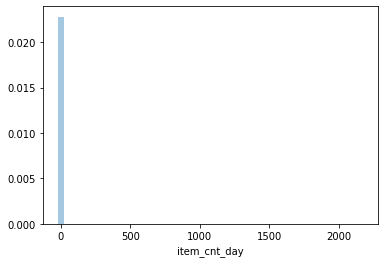

In [50]:
img = sns.distplot(df_train['item_cnt_day'])

Wow, it seems a lot of outliers must exist on the data!

This is clearly not normally distributed.

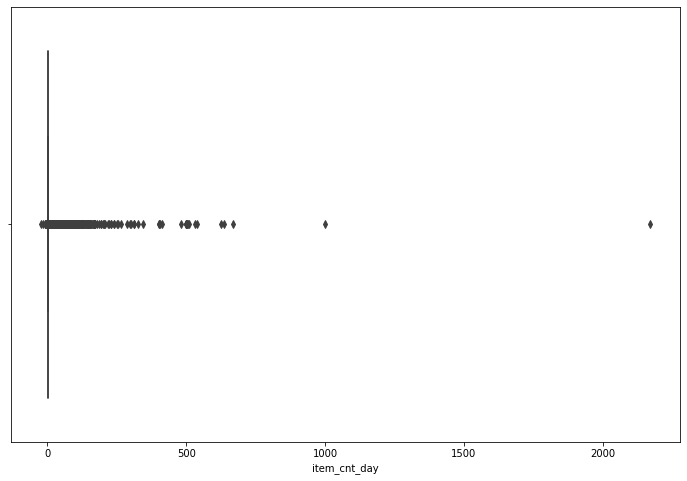

In [51]:
fig = plt.figure(figsize=(12,8))
fig = sns.boxplot(x='item_cnt_day',data=df_train)

There are some instances where huge numbers of items where sold in a single day.

In [52]:
#100 was selected on a mostly visual criterion (as quantile 0.99 s around 5 items a day that does still seem a very reasonable quantity)
filt = df_train['item_cnt_day'] > 200
df_train[filt]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,set,ID,year,month,day,day_of_week,shop_name_translated_no_punct,item_category_id,item_name_translated_no_punct,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category,item_subcategory
1177077,2015-04-14,27,25,3731,1941.995169,207.0,train,NaN,2015.0,4.0,14.0,Tuesday,moscow trk atrium,30,grand theft auto v pc russian subtitles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.673199,0.000000,0.0,0.739462,0.000000,0.000000,0.0,0.0,Games,PC - Standard
1178168,2015-04-14,27,12,3731,1904.548077,624.0,train,NaN,2015.0,4.0,14.0,Tuesday,online shop emergency,30,grand theft auto v pc russian subtitles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.673199,0.000000,0.0,0.739462,0.000000,0.000000,0.0,0.0,Games,PC - Standard
1178597,2015-04-14,27,42,3731,1918.732441,299.0,train,NaN,2015.0,4.0,14.0,Tuesday,spb tc nevsky center,30,grand theft auto v pc russian subtitles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.673199,0.000000,0.0,0.739462,0.000000,0.000000,0.0,0.0,Games,PC - Standard
1312930,2013-09-17,8,25,3732,2545.135417,264.0,train,NaN,2013.0,9.0,17.0,Tuesday,moscow trk atrium,19,grand theft auto v ps3 russian subtitles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.793127,0.0,0.609057,0.000000,0.000000,0.0,0.0,Games,PS3
1316160,2013-09-17,8,31,3732,2550.597222,288.0,train,NaN,2013.0,9.0,17.0,Tuesday,moscow тц семеновский,19,grand theft auto v ps3 russian subtitles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.793127,0.0,0.609057,0.000000,0.000000,0.0,0.0,Games,PS3
1317433,2013-09-18,8,42,3732,2521.211982,217.0,train,NaN,2013.0,9.0,18.0,Wednesday,spb tc nevsky center,19,grand theft auto v ps3 russian subtitles,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.793127,0.0,0.609057,0.000000,0.000000,0.0,0.0,Games,PS3
2133413,2015-05-19,28,12,10209,1499.000000,480.0,train,NaN,2015.0,5.0,19.0,Tuesday,online shop emergency,28,witcher 3 wild hunt pc russian version,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.570041,0.000000,0.0,0.626150,0.000000,0.531968,0.0,0.0,Games,PC - Additional
2864116,2014-06-28,17,25,20949,5.000000,501.0,train,NaN,2014.0,6.0,28.0,Saturday,moscow trk atrium,71,corporate package tshirt 1c interest white 34 ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,Gifts,"Bags, Albums, Mouse pads"
2864302,2014-12-30,23,25,20949,5.000000,205.0,train,NaN,2014.0,12.0,30.0,Tuesday,moscow trk atrium,71,corporate package tshirt 1c interest white 34 ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,Gifts,"Bags, Albums, Mouse pads"
2864323,2015-01-17,24,25,20949,5.000000,222.0,train,NaN,2015.0,1.0,17.0,Saturday,moscow trk atrium,71,corporate package tshirt 1c interest white 34 ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,Gifts,"Bags, Albums, Mouse pads"


Interestingly, some of the items that sell the most are associated with a "online shop emergency" that has Delivery of Goods as item category. Video games are also strong sellers as are payment cards and corporate gifts (tshirt).

In [53]:
filt = (df_train['item_category']=='Delivery of goods')
df_train[filt]['shop_id'].value_counts()

12    2193
Name: shop_id, dtype: int64

This is exclusive of the apparently online store and includes some sort of delivery "sale".

In [54]:
filt = df_train['item_name_translated_no_punct'].str.contains('delivery')
list_delivery_item_id = df_train[filt]['item_id'].unique()

In [55]:
filt = (df_test['shop_id'] == 12) & (df_test['item_id'].isin(list_delivery_item_id))
df_test[filt]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,set,ID,year,month,day,day_of_week,shop_name_translated_no_punct,item_category_id,item_name_translated_no_punct,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category,item_subcategory
2813951,NaT,34,12,478,NaN,NaN,test,37432.0,NaN,NaN,NaN,NaN,online shop emergency,73,1c accounting 8 prof delivery for retail distr...,0.710415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.703783,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Programs,1C: Enterprise 8
2814178,NaT,34,12,477,NaN,NaN,test,39612.0,NaN,NaN,NaN,NaN,online shop emergency,73,1c accounting 8 prof delivery for retail distr...,0.710415,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.703783,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Programs,1C: Enterprise 8
3122023,NaT,34,12,11373,NaN,NaN,test,37296.0,NaN,NaN,NaN,NaN,online shop emergency,9,delivery to the point of issue boxberry,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.712592,0.0,0.0,0.0,0.0,0.701579,0.0,0.0,0.0,Delivery of goods,None
3122127,NaT,34,12,11371,NaN,NaN,test,37306.0,NaN,NaN,NaN,NaN,online shop emergency,9,delivery alternative in moscow,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Delivery of goods,None
3122284,NaT,34,12,11372,NaN,NaN,test,37307.0,NaN,NaN,NaN,NaN,online shop emergency,9,postdelivery pickpoint,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Delivery of goods,None
3122743,NaT,34,12,11369,NaN,NaN,test,37325.0,NaN,NaN,NaN,NaN,online shop emergency,9,delivery mail,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Delivery of goods,None
3123409,NaT,34,12,11370,NaN,NaN,test,37341.0,NaN,NaN,NaN,NaN,online shop emergency,9,delivery in moscow,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Delivery of goods,None
3123899,NaT,34,12,13753,NaN,NaN,test,39455.0,NaN,NaN,NaN,NaN,online shop emergency,9,courier delivery boxberry,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Delivery of goods,None
3124014,NaT,34,12,13754,NaN,NaN,test,39456.0,NaN,NaN,NaN,NaN,online shop emergency,9,courier delivery of spb grastin,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,Delivery of goods,None


The deliveries appear also on the test set, so let's just exclude all values above 1000.

In [56]:
df_train = df_train[df_train['item_cnt_day'] < 1000]

Let's plot by date.

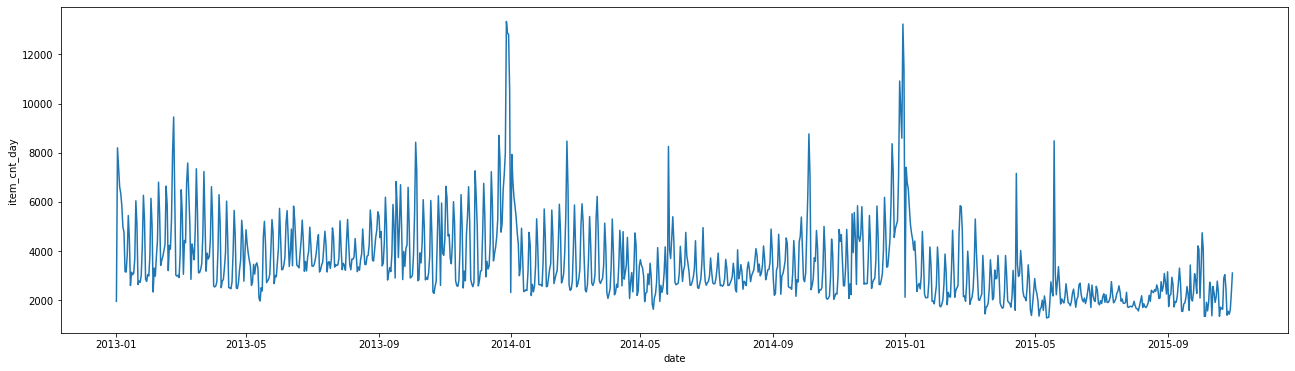

In [57]:
tmp = pd.DataFrame(df_train.groupby('date')['item_cnt_day'].sum()).reset_index()

fig = plt.figure(figsize=(22,6))
fig = sns.lineplot(x='date',y='item_cnt_day',data=tmp)

Data is noisy. Let's check moving average with weekly windows.

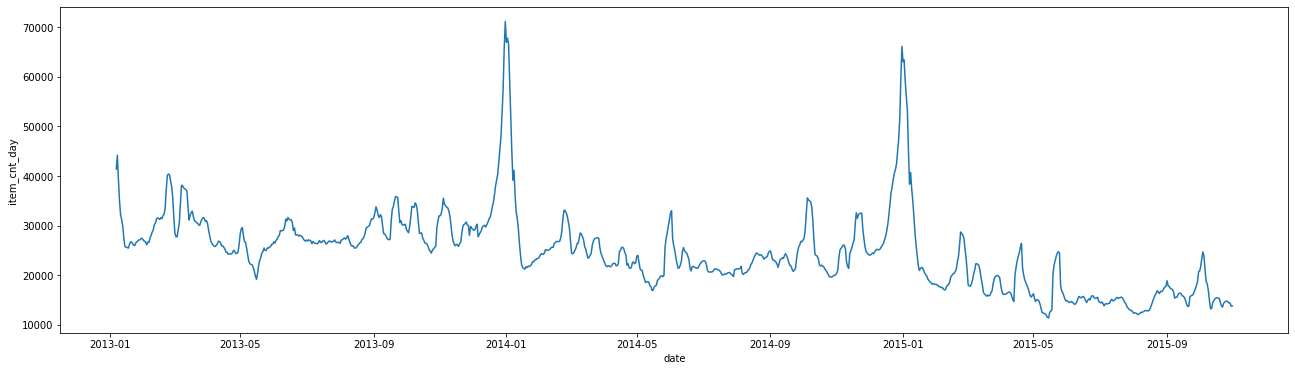

In [58]:
window_size = 7
tmp = pd.DataFrame(df_train.groupby('date')['item_cnt_day'].sum()).reset_index()
tmp = tmp.rolling(window_size).sum()
tmp['date'] = df_train.groupby('date')['item_cnt_day'].sum().index

fig = plt.figure(figsize=(22,6))
fig = sns.lineplot(x='date',y='item_cnt_day',data=tmp)

There seems to be a decreasing tendency on the dataset, with some visible peaks and troughs (seasonality).
Time around christmas and new year seems to be a strong time for sales.

Let's plot by month.

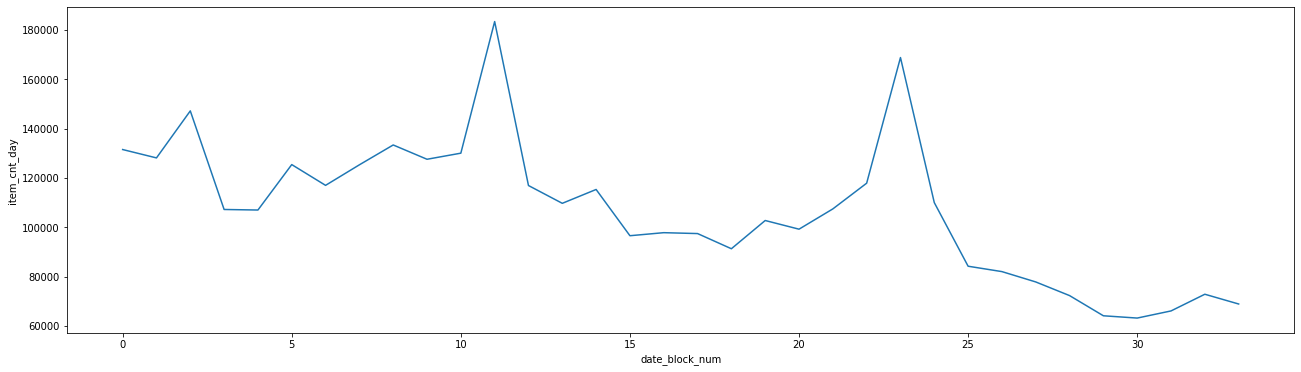

In [59]:
window_size = 1
tmp = pd.DataFrame(df_train.groupby('date_block_num')['item_cnt_day'].sum()).reset_index()
tmp = tmp.rolling(window_size).sum()
tmp['date'] = df_train.groupby('date_block_num')['item_cnt_day'].sum().index

fig = plt.figure(figsize=(22,6))
fig = sns.lineplot(x='date_block_num',y='item_cnt_day',data=tmp)

#### Refunds

Sometimes items are returned.

In [60]:
df_train[df_train['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,set,ID,year,month,day,day_of_week,shop_name_translated_no_punct,item_category_id,item_name_translated_no_punct,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category,item_subcategory
421,2015-05-19,28,31,8095,499.00,-1.0,train,NaN,2015.0,5.0,19.0,Tuesday,moscow тц семеновский,37,avatar bd dvd,0.0,0.0,0.0,0.0,0.605266,0.000000,0.0,0.0,0.0,0.796023,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
589,2013-02-17,1,44,8095,499.00,-1.0,train,NaN,2013.0,2.0,17.0,Sunday,samara tp melody,37,avatar bd dvd,0.0,0.0,0.0,0.0,0.605266,0.000000,0.0,0.0,0.0,0.796023,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
596,2015-04-01,27,44,8095,499.00,-1.0,train,NaN,2015.0,4.0,1.0,Wednesday,samara tp melody,37,avatar bd dvd,0.0,0.0,0.0,0.0,0.605266,0.000000,0.0,0.0,0.0,0.796023,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
623,2014-07-25,18,45,8095,499.00,-1.0,train,NaN,2014.0,7.0,25.0,Friday,samara tc parkhaus,37,avatar bd dvd,0.0,0.0,0.0,0.0,0.605266,0.000000,0.0,0.0,0.0,0.796023,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
694,2014-07-19,18,25,8266,199.34,-1.0,train,NaN,2014.0,7.0,19.0,Saturday,moscow trk atrium,37,american pie all in assembly bd,0.0,0.0,0.0,0.0,0.613322,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.789833,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cinema,Blu-Ray
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124059,2014-08-19,19,12,11368,500.00,-1.0,train,NaN,2014.0,8.0,19.0,Tuesday,online shop emergency,9,delivery courier,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delivery of goods,None
3124067,2014-08-12,19,12,11367,250.00,-1.0,train,NaN,2014.0,8.0,12.0,Tuesday,online shop emergency,9,delivery cleologistic,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delivery of goods,None
3124068,2014-08-07,19,12,11367,375.00,-2.0,train,NaN,2014.0,8.0,7.0,Thursday,online shop emergency,9,delivery cleologistic,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delivery of goods,None
3124069,2014-08-04,19,12,11367,250.00,-2.0,train,NaN,2014.0,8.0,4.0,Monday,online shop emergency,9,delivery cleologistic,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delivery of goods,None


## item_price

In [61]:
df_train['item_price'].describe()

count    2.935847e+06
mean     8.908538e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

There shouldn't be any negative values on the data. These must correspond to missing values.

In [62]:
print('There are {} negative or free items in the dataset.'.format(df_train[df_train['item_price'] <= 0].shape[0]))

There are 1 negative or free items in the dataset.


In [63]:
tmp_item_id = df_train[df_train['item_price'] <= 0]['item_id'].values[0]
tmp_shop_id = df_train[df_train['item_price'] <= 0]['shop_id'].values[0]
filt = (df_train['item_id'] == tmp_item_id) & (df_train['shop_id'] == tmp_shop_id) & (df_train['item_price'] > 0)
print('There are {} distinct prices corresponding to this item.'.format(df_train[filt]['item_price'].nunique()))

There are 3 distinct prices corresponding to this item.


Let's use the mean value from these 3 possibilities to replace the negative value.

In [64]:
df_train.loc[df_train['item_price'] <= 0,'item_price'] = df_train[filt]['item_price'].mean()
#House cleaning
del tmp_item_id,tmp_shop_id

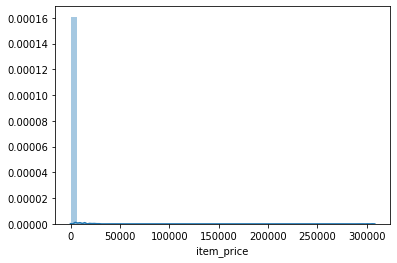

In [65]:
img = sns.distplot(df_train['item_price'])

Again, most values are pretty low, but some very large ones exist! 

This could spell doom to a linear model.

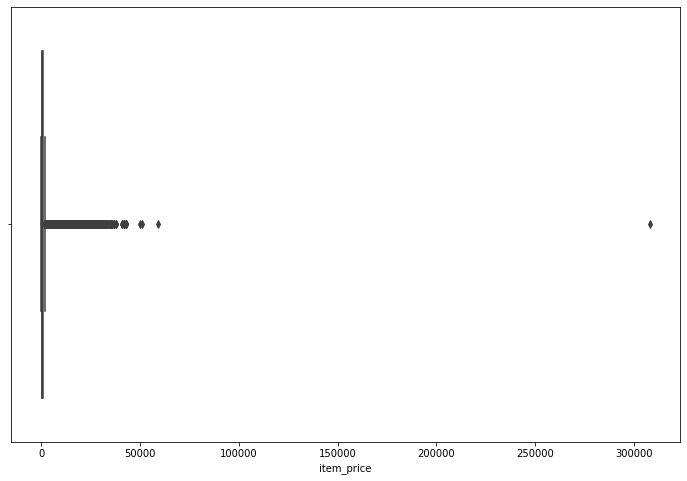

In [66]:
fig = plt.figure(figsize=(12,8))
fig = sns.boxplot(x='item_price',data=df_train)

We have an absolutely enourmosly expensive item on the dataset.

In [67]:
filt = df_train['item_price'] > 250000
df_train[filt]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,set,ID,year,month,day,day_of_week,shop_name_translated_no_punct,item_category_id,item_name_translated_no_punct,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24,item_category,item_subcategory
2204942,2013-12-13,11,12,6066,307980.0,1.0,train,NaN,2013.0,12.0,13.0,Friday,online shop emergency,75,radmin 3 522 people,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Programs,Home and Office


Let's drop it as it does not seem to be a normal purchase (software for 3522 people).

In [68]:
df_train = df_train[df_train['item_price'] < 250000]

## Item category

In [69]:
df_train['item_category_id'].nunique()

84

In [70]:
df_train['item_category_id'].unique()

array([37, 40,  5,  2, 30, 19, 55, 59, 22, 23, 21, 62, 28, 35, 75, 29, 63,
       38,  6, 15, 33, 69, 25, 13,  4, 56, 49, 41, 57, 64, 65, 67, 72, 83,
        3, 70, 11, 60, 73, 14, 79, 43, 45, 71, 61, 77, 58, 20, 12, 32, 39,
       66, 17, 16,  8, 24,  7, 47, 42, 80, 31,  9,  0, 54, 76, 78, 34, 36,
       27, 26, 74, 44, 68, 82, 81, 46, 18, 10, 52, 53,  1, 50, 48, 51],
      dtype=int64)

In [71]:
df_train['item_category_id'].value_counts()

40    564652
30    351591
55    339585
19    208219
37    192674
       ...  
0          3
50         2
1          2
10         1
51         1
Name: item_category_id, Length: 84, dtype: int64

We should bin the infrequent categories into a single category group.

In [72]:
df_train['item_category_id'].value_counts().values

array([564652, 351591, 339585, 208219, 192674, 146789, 121539,  79058,
        53845,  53227,  47177,  42718,  42602,  41706,  37635,  35484,
        32748,  32490,  32164,  31396,  26822,  26537,  25949,  25283,
        23851,  23708,  23166,  20649,  18576,  18498,  18461,  14891,
        13702,  12780,  12257,  12237,   9067,   7931,   7924,   7402,
         7231,   7206,   6629,   6109,   5657,   5360,   5234,   5175,
         4875,   4848,   4459,   4390,   3746,   3703,   2974,   2835,
         2346,   2304,   2247,   2192,   1921,   1877,   1525,   1325,
          795,    624,    355,    322,    248,    123,     91,     56,
           19,     15,     11,      8,      6,      3,      3,      3,
            2,      2,      1,      1], dtype=int64)

So 84 categories exist but some represent almost no data!

We should group these together.

In [73]:
filt = df_train['item_category_id'].isin(df_train['item_category_id'].value_counts()[df_train['item_category_id'].value_counts() >= 1000].index.tolist())
df_train[filt]['item_category_id'].nunique()

64

Let's merge these categories together.

In [74]:
#Merge category id with less than 1000 frequency together
aux = df_train['item_category_id'].value_counts()[df_train['item_category_id'].value_counts() < 1000].index
df_sales.loc[df_sales['item_category_id'].isin(aux),'item_category_id'] = 1

#Convert to categorical type
df_sales['item_category_id'] = df_sales['item_category_id'].astype('category')

## Dates

In [75]:
df_train['date'].max()-df_train['date'].min()

Timedelta('1033 days 00:00:00')

There are 1033 days of data.

In [76]:
#df_train.groupby('day_of_week')['item_cnt_day'].sum()

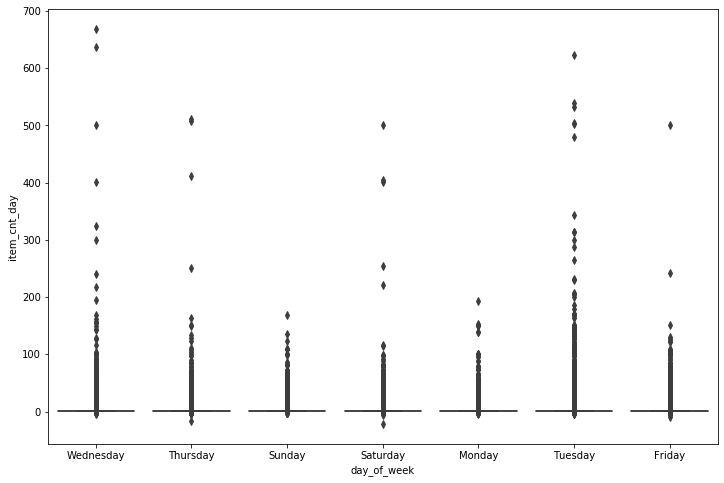

In [77]:
fig = plt.figure(figsize=(12,8))
fig = sns.boxplot(x='day_of_week',y='item_cnt_day',data=df_train)

# Feature Engineering

## Create the Training/Test Set

We are going to be predicting sales on a monthly basis and only have daily sales information on the training set. 

We therefore need to convert this daily sales information to monthly basis before passing this data to the model. Let's create a new DataFrame where we will be storing new features to be used by the model.

In [78]:
#Create combinations of shop_id, item_id that appear in each month  - This creates alot of rows (more than 10 M)
tmp = []
for i in range(df_sales['date_block_num'].max()+1):
    filt = df_sales['date_block_num'] == i
    tmp = tmp + list(product([i],df_sales[filt]['shop_id'].unique(),df_sales[filt]['item_id'].unique()))
df_model = pd.DataFrame(tmp,columns = ['date_block_num','shop_id','item_id'])
#Drop temporary list
del tmp
    
#Create every possible combination of shop_id, item_id and month - This creates alot of rows (more than 49 M)
#comb = list(product(df_sales['date_block_num'].unique(),df_sales['shop_id'].unique(),df_sales['item_id'].unique()))
#Create the DataFrame
#df_model = pd.DataFrame(comb,columns = ['date_block_num','shop_id','item_id'])
#Drop temporary list
#del comb

#Use only combinations found already in the data
#df_model = df_sales[['date_block_num','shop_id','item_id']].drop_duplicates()

#Calculate the item sales 
tmp = pd.DataFrame(df_sales.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum(min_count=1))
tmp = tmp.rename(columns={'item_cnt_day':'item_cnt_month'})
tmp = tmp.reset_index()
tmp['item_cnt_month'] = tmp['item_cnt_month'].clip(0,20) #Clip to 0,20 as the final predictions are also clipped to that range
#Add the aggregated item sales to the model DataFrame
df_model = pd.merge(df_model,tmp,on=['date_block_num','shop_id','item_id'],how='left')

#Fill missing values with 0 of the training set.
df_model.loc[df_model['date_block_num'] < 34,'item_cnt_month'] = df_model[df_model['date_block_num'] < 34]['item_cnt_month'].fillna(0)
#Sort DataFrame
df_model = df_model.sort_values(['date_block_num','shop_id','item_id'],ascending=True)

#Merge ID
tmp = df_sales[df_sales['set']=='test'][['ID','shop_id','item_id']].drop_duplicates()
tmp['ID'] = tmp['ID'].astype('uint32')
df_model = pd.merge(df_model,tmp,on=['shop_id','item_id'],how='left')
del tmp

### Downcast

In [79]:
#Reduce size of Dataframe
df_model['date_block_num'] = df_model['date_block_num'].astype('uint16')
df_model['shop_id'] = df_model['shop_id'].astype('uint32').astype('category')
df_model['item_id'] = df_model['item_id'].astype('uint32').astype('category')
df_model['item_cnt_month'] = df_model['item_cnt_month'].astype('float32')

### Shops

In [80]:
#Change from Object to category
cols = df_shops.select_dtypes(include='object').columns
for i in cols:
    df_shops[i] = df_shops[i].astype('category')
    
#Add columns to DataFrame    
cols_date = ['shop_id','shop_city','shop_type']
df_model = pd.merge(df_model,df_shops[cols_date],on='shop_id',how='left')

### Items

In [81]:
#Change item_id and item_category_id to category
df_items['item_id'] = df_items['item_id'].astype('category')
df_items['item_category_id'] = df_items['item_category_id'].astype('category')

#Add columns to DataFrame    
cols_date = ['item_id','item_category_id']
df_model = pd.merge(df_model,df_items[cols_date],on='item_id',how='left')

#Get item_category and item_subcategory from the item_category_id
#Change item_id and item_category_id to category
df_item_categories['item_category_id'] = df_item_categories['item_category_id'].astype('category')
df_item_categories['item_category'] = df_item_categories['item_category'].astype('category')
df_item_categories['item_subcategory'] = df_item_categories['item_subcategory'].astype('category')

#Add columns to DataFrame    
cols_date = ['item_category_id','item_category','item_subcategory']
df_model = pd.merge(df_model,df_item_categories[cols_date],on='item_category_id',how='left')

### Date Features

In [82]:
#Create DataFrame with date info for each date_block_num
tmp = df_sales[['date_block_num','year','month']].drop_duplicates()
#Replace NaN from the test set
tmp.loc[tmp['date_block_num'] == 34,'year'] = 2015
tmp.loc[tmp['date_block_num'] == 34,'month'] = 11

#Add number of times a certain day appears on the month
tmp['year'] = tmp['year'].astype('uint16')
tmp['month'] = tmp['month'].astype('uint16')
list_days = ['monday','tuesday','wednesday','thursday','friday','saturday','sunday']
for i in range(7):
    tmp['n_'+list_days[i]] = [pd.date_range(x,y).weekday.isin([i]).sum() for x , y in zip(tmp.apply(lambda x: date(x['year'],x['month'],1),axis=1),tmp.apply(lambda x: date(x['year'],x['month'],1)+pd.DateOffset(months=1),axis=1))]

#Change year and month to category
tmp['date_block_num'] = tmp['date_block_num'].astype('category')
tmp['year'] = tmp['year'].astype('category')
tmp['month'] = tmp['month'].astype('category')
for i in range(7):
    tmp['n_'+list_days[i]] = tmp['n_'+list_days[i]].astype('uint16').astype('category')   

#Add columns to DataFrame    
df_model = pd.merge(df_model,tmp,on='date_block_num',how='left')

#Calculate number of days in a month
tmp = pd.DataFrame(df_sales[['date_block_num','date']].drop_duplicates().groupby('date_block_num')['date'].count()).reset_index()
tmp['date_block_num'] = tmp['date_block_num'].astype('category')
#Rename column
tmp = tmp.rename(columns={'date':'n_days'})
tmp['n_days'] = tmp['n_days'].astype('category')

#Add columns to DataFrame    
df_model = pd.merge(df_model,tmp,on='date_block_num',how='left')

#Extract holidays and add information on them (n_holidays per month, important holidays explicitly)


In [83]:
df_model.head()  

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_city,shop_type,item_category_id,item_category,item_subcategory,year,month,n_monday,n_tuesday,n_wednesday,n_thursday,n_friday,n_saturday,n_sunday,n_days
0,0,0,19,0.0,NaN,yakutsk,ordzhonikidze,40,Cinema,DVD,2013,1,4,5,5,5,5,4,4,31
1,0,0,27,0.0,NaN,yakutsk,ordzhonikidze,19,Games,PS3,2013,1,4,5,5,5,5,4,4,31
2,0,0,28,0.0,NaN,yakutsk,ordzhonikidze,30,Games,PC - Standard,2013,1,4,5,5,5,5,4,4,31
3,0,0,29,0.0,NaN,yakutsk,ordzhonikidze,23,Games,XBOX 360,2013,1,4,5,5,5,5,4,4,31
4,0,0,32,6.0,NaN,yakutsk,ordzhonikidze,40,Cinema,DVD,2013,1,4,5,5,5,5,4,4,31


### Sale Price

A sale price can vary during a month for certain item/shop combinations. 

We can generate several features for this, mean, median, min, max prices for example.

In [84]:
df_model.head(1)

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_city,shop_type,item_category_id,item_category,item_subcategory,year,month,n_monday,n_tuesday,n_wednesday,n_thursday,n_friday,n_saturday,n_sunday,n_days
0,0,0,19,0.0,NaN,yakutsk,ordzhonikidze,40,Cinema,DVD,2013,1,4,5,5,5,5,4,4,31


## item_category and subcategory

### item_category

In [85]:
df_model['item_category'].value_counts()

Cinema                    4153431
Music                     2424306
Games                     1886205
Gifts                     1472572
Books                      587469
Programs                   335468
Accessories                147291
Game Consoles               64429
Payment cards               27261
Delivery of goods            9724
Elements of a food           7471
Clean media (piece)          4108
Clean carriers (spire)       2576
Tickets (figure)             2225
Office                       1628
Official                     1572
PC                            179
Книги                         135
Name: item_category, dtype: int64

Some categories are quite infrequent and therefore should not be considered by themselves, they will not help in generalizing.

In [86]:
df_model['item_category'] = df_model['item_category'].astype('object')
#Merge category id with less than 1000 frequency together
aux = df_model['item_category'].value_counts()[df_model['item_category'].value_counts() < 1000].index
df_model.loc[df_model['item_category'].isin(aux),'item_category'] = 'Others'

#Convert to categorical type
df_model['item_category'] = df_model['item_category'].astype('category')

### item_subcategory

In [87]:
df_model['item_subcategory'].value_counts()

DVD                       2528576
CD of local production    1583333
Blu-Ray                   1159867
PS3                        407137
PC                         406435
                           ...   
Headsets / Headphones         179
Fiction                       138
Путеводители                  135
Postcards                      92
Cognitive Literature           50
Name: item_subcategory, Length: 65, dtype: int64

There are 32 subcategories. Again some are infrequent and can be grouped together.

In [88]:
df_model['item_subcategory'] = df_model['item_subcategory'].astype('object')
#Merge category id with less than 1000 frequency together
aux = df_model['item_subcategory'].value_counts()[df_model['item_subcategory'].value_counts() < 1000].index
df_model.loc[df_model['item_subcategory'].isin(aux),'item_subcategory'] = 'Others'

#Convert to categorical type
df_model['item_subcategory'] = df_model['item_subcategory'].astype('category')

### Mean Encodings

Before making mean encodings we should take care to calculate them based only on the train set to map to validation set later, as well as the train/val set to map to test set.

We are considering test set at month 34, validation as 33 and 0 to 32 as train set.

In [89]:
filt_sales_train = df_sales['date_block_num'] < 33
filt_sales_val = df_sales['date_block_num'] == 33
filt_sales_test = df_sales['date_block_num'] == 34

filt_model_train = df_model['date_block_num'] < 33
filt_model_val = df_model['date_block_num'] == 33
filt_model_test = df_model['date_block_num'] == 34

#### price

In [90]:
#Calculate mean sale price of each week - For validation split
df_sales_price = df_sales.groupby(['date_block_num','shop_id','item_id'])['item_price'].agg(['min','mean','max']).reset_index()
df_sales_price = df_sales_price.rename(columns={'min':'price_min','mean':'price_mean','max':'price_max'})
#Add current weeks sale price
df_model = pd.merge(df_model,df_sales_price,on=['date_block_num','shop_id','item_id'],how='left')

#### item all time

In [91]:
#calculate min, mean and max price per item (all time)
df_sales_price = df_sales[filt_sales_train].groupby(['item_id'])['item_price'].agg(['min','mean','max']).reset_index()
df_sales_price = df_sales_price.rename(columns={'min':'price_alltime_min','mean':'price_alltime_mean','max':'price_alltime_max'})

In [92]:
df_sales_price[df_sales_price['price_alltime_mean'].isna()]

,item_id,price_alltime_min,price_alltime_mean,price_alltime_max


363 products have no price. This can be problematic for the model...

In [93]:
df_model = pd.merge(df_model,df_sales_price,on=['item_id'],how='left')

#### monthly item

In [94]:
#calculate min, mean and max price per item (all time)
df_sales_price = df_sales.groupby(['date_block_num','item_id'])['item_price'].agg(['mean']).reset_index()
df_sales_price = df_sales_price.rename(columns={'mean':'price_monthly_mean'})

In [95]:
df_model = pd.merge(df_model,df_sales_price,on=['date_block_num','item_id'],how='left')

#### shop item

In [96]:
#calculate min, mean and max price per item (all time)
df_sales_price = df_sales[filt_sales_train].groupby(['shop_id','item_id'])['item_price'].agg(['mean']).reset_index()
df_sales_price = df_sales_price.rename(columns={'mean':'price_shop_mean'})
df_model = pd.merge(df_model,df_sales_price,on=['shop_id','item_id'],how='left')

### Revenue

In [97]:
df_sales['revenue'] = df_sales['item_price']*df_sales['item_cnt_day']
tmp = df_sales.groupby(['date_block_num','shop_id','item_id'])['revenue'].sum().reset_index()
df_model = pd.merge(df_model,tmp,on=['date_block_num','shop_id','item_id'],how='left')

#### Average Revenue of shop (all time)

In [98]:
tmp= df_model[filt_model_train].groupby('shop_id')['revenue'].mean().reset_index()
tmp = tmp.rename(columns={'revenue':'shop_alltime_avg_revenue'})
df_model = pd.merge(df_model,tmp,on='shop_id',how='left')

#### Average Monthly Revenue of Shop

In [99]:
tmp= df_model.groupby(['date_block_num','shop_id'])['revenue'].mean().reset_index()
tmp = tmp.rename(columns={'revenue':'shop_monthly_avg_revenue'})
df_model = pd.merge(df_model,tmp,on=['date_block_num','shop_id'],how='left')

## Lag based Features

### item_cnt_day

In [100]:
def get_lags(df,lags,col):
    """
    This function will get the lagged values of the col on the specified intervals. It does so without using groupby.shift as we do not have rows for each date_block_num, shop_id, item_id combination.
    
    inputs: df - DataFrame with the data
            lags - list with integers representing the desired time lags
            col - string containing the name of the column that will be retrieved with lags.
            
    outputs: df - The input DataFrame with the new lagged columns
    """    
    for i in lags:
        #Create a temporary DataFrame with the important columns
        tmp = df[['date_block_num','shop_id','item_id',col]]
        
        tmp = tmp.rename(columns={col:col+'_lag'+str(i)})
        tmp['date_block_num'] = tmp['date_block_num']+i
        df = pd.merge(df,tmp,on=['date_block_num','shop_id','item_id'],how='left')  
        
    return df

In [101]:
#Get lagged features
df_model = get_lags(df_model,[1,2,3,6,12],'item_cnt_month')

### item_price

In [102]:
df_model.head(1)

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_city,shop_type,item_category_id,item_category,item_subcategory,year,month,n_monday,n_tuesday,n_wednesday,n_thursday,n_friday,n_saturday,n_sunday,n_days,price_min,price_mean,price_max,price_alltime_min,price_alltime_mean,price_alltime_max,price_monthly_mean,price_shop_mean,revenue,shop_alltime_avg_revenue,shop_monthly_avg_revenue,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,item_cnt_month_lag6,item_cnt_month_lag12
0,0,0,19,0.0,NaN,yakutsk,ordzhonikidze,40,Cinema,DVD,2013,1,4,5,5,5,5,4,4,31,NaN,NaN,NaN,28.0,28.0,28.0,28.0,NaN,NaN,1376.762083,1243.778616,NaN,NaN,NaN,NaN,NaN


In [103]:
#Get lagged features for mean price for item/shop/month
df_model = get_lags(df_model,[1,2,3,6,12],'price_mean')

#Get lagged features for mean price of each item/month
df_model = get_lags(df_model,[1,2,3,6,12],'price_monthly_mean')

#Get lagged features for mean price of each shop/month
df_model = get_lags(df_model,[1,2,3,6,12],'price_shop_mean')

#### Trends

In [104]:
for i in [1,2,3,6,12]:
    df_model['price_trend_monthly_lag_'+str(i)] = (df_model['price_monthly_mean_lag'+str(i)]-df_model['price_mean'])/df_model['price_mean']

### revenue

#### lag or revenue

In [105]:
#Get lagged features for mean price for item/shop/month
df_model = get_lags(df_model,[1,2,3,6,12],'shop_monthly_avg_revenue')

#### Trend of Shop Revenue

In [106]:
for i in [1,2,3,6,12]:
    df_model['revenue_shop_trend_monthly_lag_'+str(i)] = (df_model['shop_monthly_avg_revenue_lag'+str(i)]-df_model['shop_alltime_avg_revenue'])/df_model['shop_alltime_avg_revenue']

## Lagged Mean Encodings

### item_cnt_monthly

In [107]:
tmp = pd.DataFrame(df_model.groupby('date_block_num')['item_cnt_month'].mean())
tmp.columns = ['item_cnt_month_mean']
tmp = tmp.reset_index()

#Let's add lags
for i in [1,2,3,6,12]:
    tmp2 = tmp.copy()
    tmp2['date_block_num'] = tmp2['date_block_num']+1
    tmp2 = tmp2.rename(columns={'item_cnt_month_mean':'item_cnt_monthly_average_lag_'+str(i)})
    df_model = pd.merge(df_model,tmp2,on='date_block_num',how='left')
    
del tmp, tmp2

### item_cnt_by_item_monthly

In [108]:
tmp = pd.DataFrame(df_model.groupby(['date_block_num','item_id'])['item_cnt_month'].mean())
tmp.columns = ['item_cnt_month_mean']
tmp = tmp.reset_index()

#Let's add lags
for i in [1,2,3,6,12]:
    tmp2 = tmp.copy()
    tmp2['date_block_num'] = tmp2['date_block_num']+1
    tmp2 = tmp2.rename(columns={'item_cnt_month_mean':'item_cnt_by_item_monthly_average_lag_'+str(i)})
    df_model = pd.merge(df_model,tmp2,on=['date_block_num','item_id'],how='left')
    
del tmp, tmp2

### item_cnt_by_shop_monthly

In [109]:
tmp = pd.DataFrame(df_model.groupby(['date_block_num','shop_id'])['item_cnt_month'].mean())
tmp.columns = ['item_cnt_month_mean']
tmp = tmp.reset_index()

#Let's add lags
for i in [1,2,3,6,12]:
    tmp2 = tmp.copy()
    tmp2['date_block_num'] = tmp2['date_block_num']+1
    tmp2 = tmp2.rename(columns={'item_cnt_month_mean':'item_cnt_by_shop_monthly_average_lag_'+str(i)})
    df_model = pd.merge(df_model,tmp2,on=['date_block_num','shop_id'],how='left')
    
del tmp, tmp2

### item_cnt_by_item_shop_monthly

In [110]:
tmp = pd.DataFrame(df_model.groupby(['date_block_num','shop_id','item_id'])['item_cnt_month'].mean())
tmp.columns = ['item_cnt_month_mean']
tmp = tmp.reset_index()

#Let's add lags
for i in [1,2,3,6,12]:
    tmp2 = tmp.copy()
    tmp2['date_block_num'] = tmp2['date_block_num']+1
    tmp2 = tmp2.rename(columns={'item_cnt_month_mean':'item_cnt_by_item_shop_monthly_average_lag_'+str(i)})
    df_model = pd.merge(df_model,tmp2,on=['date_block_num','shop_id','item_id'],how='left')
    
del tmp, tmp2

### item_cnt_by_item_category_monthly

In [111]:
tmp = pd.DataFrame(df_model.groupby(['date_block_num','item_category'])['item_cnt_month'].mean())
tmp.columns = ['item_cnt_month_mean']
tmp = tmp.reset_index()

#Let's add lags
for i in [1,12]:
    tmp2 = tmp.copy()
    tmp2['date_block_num'] = tmp2['date_block_num']+1
    tmp2 = tmp2.rename(columns={'item_cnt_month_mean':'item_cnt_by_item_category_monthly_average_lag_'+str(i)})
    df_model = pd.merge(df_model,tmp2,on=['date_block_num','item_category'],how='left')
    
del tmp, tmp2

### item_cnt_by_item_subcategory_monthly

In [112]:
tmp = pd.DataFrame(df_model.groupby(['date_block_num','item_subcategory'])['item_cnt_month'].mean())
tmp.columns = ['item_cnt_month_mean']
tmp = tmp.reset_index()

#Let's add lags
for i in [1,12]:
    tmp2 = tmp.copy()
    tmp2['date_block_num'] = tmp2['date_block_num']+1
    tmp2 = tmp2.rename(columns={'item_cnt_month_mean':'item_cnt_by_item_subcategory_monthly_average_lag_'+str(i)})
    df_model = pd.merge(df_model,tmp2,on=['date_block_num','item_subcategory'],how='left')
    
del tmp, tmp2

In [113]:
df_model.head(1)

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_city,shop_type,item_category_id,item_category,item_subcategory,year,month,n_monday,n_tuesday,n_wednesday,n_thursday,n_friday,n_saturday,n_sunday,n_days,price_min,price_mean,price_max,price_alltime_min,price_alltime_mean,price_alltime_max,price_monthly_mean,price_shop_mean,revenue,shop_alltime_avg_revenue,shop_monthly_avg_revenue,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,item_cnt_month_lag6,item_cnt_month_lag12,price_mean_lag1,price_mean_lag2,price_mean_lag3,price_mean_lag6,price_mean_lag12,price_monthly_mean_lag1,price_monthly_mean_lag2,price_monthly_mean_lag3,price_monthly_mean_lag6,price_monthly_mean_lag12,price_shop_mean_lag1,price_shop_mean_lag2,price_shop_mean_lag3,price_shop_mean_lag6,price_shop_mean_lag12,price_trend_monthly_lag_1,price_trend_monthly_lag_2,price_trend_monthly_lag_3,price_trend_monthly_lag_6,price_trend_monthly_lag_12,shop_monthly_avg_revenue_lag1,shop_monthly_avg_revenue_lag2,shop_monthly_avg_revenue_lag3,shop_monthly_avg_revenue_lag6,shop_monthly_avg_revenue_lag12,revenue_shop_trend_monthly_lag_1,revenue_shop_trend_monthly_lag_2,revenue_shop_trend_monthly_lag_3,revenue_shop_trend_monthly_lag_6,revenue_shop_trend_monthly_lag_12,item_cnt_monthly_average_lag_1,item_cnt_monthly_average_lag_2,item_cnt_monthly_average_lag_3,item_cnt_monthly_average_lag_6,item_cnt_monthly_average_lag_12,item_cnt_by_item_monthly_average_lag_1,item_cnt_by_item_monthly_average_lag_2,item_cnt_by_item_monthly_average_lag_3,item_cnt_by_item_monthly_average_lag_6,item_cnt_by_item_monthly_average_lag_12,item_cnt_by_shop_monthly_average_lag_1,item_cnt_by_shop_monthly_average_lag_2,item_cnt_by_shop_monthly_average_lag_3,item_cnt_by_shop_monthly_average_lag_6,item_cnt_by_shop_monthly_average_lag_12,item_cnt_by_item_shop_monthly_average_lag_1,item_cnt_by_item_shop_monthly_average_lag_2,item_cnt_by_item_shop_monthly_average_lag_3,item_cnt_by_item_shop_monthly_average_lag_6,item_cnt_by_item_shop_monthly_average_lag_12,item_cnt_by_item_category_monthly_average_lag_1,item_cnt_by_item_category_monthly_average_lag_12,item_cnt_by_item_subcategory_monthly_average_lag_1,item_cnt_by_item_subcategory_monthly_average_lag_12
0,0,0,19,0.0,NaN,yakutsk,ordzhonikidze,40,Cinema,DVD,2013,1,4,5,5,5,5,4,4,31,NaN,NaN,NaN,28.0,28.0,28.0,28.0,NaN,NaN,1376.762083,1243.778616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fill NaN

In [114]:
cols_fill_na = [i for i in df_model.columns if ('lag' in i) and ('item_cnt' in i)]
for i in cols_fill_na:
    df_model[i] = df_model[i].fillna(0)

### Start and End of Item Sales

#### By shop

In [115]:
map_shop = df_model.groupby('shop_id')['date_block_num'].min() 
df_model['shop_open_month'] = df_model['shop_id'].map(map_shop)
    
#map_shop = df_model.groupby('shop_id')['date_block_num'].max() 
#df_model['shop_close_month'] = df_model['shop_id'].map(map_shop)

We can now determine the number of months since store opening/closure.

In [116]:
df_model['months_since_shop_open'] =  df_model['date_block_num'] - df_model['shop_open_month']
#df_model['months_until_shop_close'] =  df_model['shop_close_month'] - df_model['date_block_num']

#### By item

In [117]:
map_item = df_model.groupby('item_id')['date_block_num'].min() 
df_model['item_starts_selling_month'] = df_model['item_id'].map(map_item)

#map_item = df_model.groupby('item_id')['date_block_num'].max() 
#df_model['item_stops_selling_month'] = df_model['item_id'].map(map_item)

In [118]:
df_model['months_since_item_sold'] =  df_model['date_block_num'] - df_model['item_starts_selling_month']
#df_model['months_until_item_stops_sale'] =  df_model['item_stops_selling_month'] - df_model['date_block_num']

### Add Item Features

In [119]:
df_model = pd.merge(df_model,df_items[[i for i in df_items if ('item_name_translated' not in i) and ('item_category_id' not in i)]],on='item_id')

### Saving to Pickle

So that we don't have to go through the lengthy feature extraction stage, we will store the dataframe. We can then load it at will if necessary.

In [120]:
df_model.to_pickle('.\\data_files\\processed_df_model.pkl')

### Reading Pickle

In [121]:
df_model = pd.read_pickle('.\\data_files\\processed_df_model.pkl')

In [122]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Columns: 119 entries, date_block_num to item_name_tfidf_24
dtypes: category(15), float32(30), float64(67), int64(2), object(4), uint64(1)
memory usage: 7.6+ GB


### Downcasting

In [123]:
cols_uint16 = ['date_block_num','n_days', 'n_friday', 'n_monday', 'n_saturday', 'n_sunday','n_thursday', 'n_tuesday', 'n_wednesday']
cols_category = ['shop_city','shop_type','item_category','item_subcategory','year','month','shop_id','item_id','item_category_id','ID','item_starts_selling_month','shop_open_month']
cols_int16 = ['months_since_shop_open','months_since_item_sold']
cols_int32 = [i for i in df_model.columns if ('item_cnt' in i) and (i != 'item_cnt_month')]
cols_float32 = [i for i in df_model.columns if ('price' in i) or ('revenue' in i) or ('tfidf' in i)]

df_model[cols_uint16] = df_model[cols_uint16].astype('uint16')
df_model[cols_category] = df_model[cols_category].astype('category')
df_model[cols_int16] = df_model[cols_int16].astype('int16')
df_model[cols_int32] = df_model[cols_int32].astype('int32')
df_model[cols_float32] = df_model[cols_float32].astype('float32')

In [124]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11128050 entries, 0 to 11128049
Columns: 119 entries, date_block_num to item_name_tfidf_24
dtypes: category(12), float32(67), int16(2), int32(29), uint16(9)
memory usage: 4.5 GB


# Train/Test Split

First, let's resplit the data to train and test sets.

In [125]:
df_model.head(1)

,date_block_num,shop_id,item_id,item_cnt_month,ID,shop_city,shop_type,item_category_id,item_category,item_subcategory,year,month,n_monday,n_tuesday,n_wednesday,n_thursday,n_friday,n_saturday,n_sunday,n_days,price_min,price_mean,price_max,price_alltime_min,price_alltime_mean,price_alltime_max,price_monthly_mean,price_shop_mean,revenue,shop_alltime_avg_revenue,shop_monthly_avg_revenue,item_cnt_month_lag1,item_cnt_month_lag2,item_cnt_month_lag3,item_cnt_month_lag6,item_cnt_month_lag12,price_mean_lag1,price_mean_lag2,price_mean_lag3,price_mean_lag6,price_mean_lag12,price_monthly_mean_lag1,price_monthly_mean_lag2,price_monthly_mean_lag3,price_monthly_mean_lag6,price_monthly_mean_lag12,price_shop_mean_lag1,price_shop_mean_lag2,price_shop_mean_lag3,price_shop_mean_lag6,price_shop_mean_lag12,price_trend_monthly_lag_1,price_trend_monthly_lag_2,price_trend_monthly_lag_3,price_trend_monthly_lag_6,price_trend_monthly_lag_12,shop_monthly_avg_revenue_lag1,shop_monthly_avg_revenue_lag2,shop_monthly_avg_revenue_lag3,shop_monthly_avg_revenue_lag6,shop_monthly_avg_revenue_lag12,revenue_shop_trend_monthly_lag_1,revenue_shop_trend_monthly_lag_2,revenue_shop_trend_monthly_lag_3,revenue_shop_trend_monthly_lag_6,revenue_shop_trend_monthly_lag_12,item_cnt_monthly_average_lag_1,item_cnt_monthly_average_lag_2,item_cnt_monthly_average_lag_3,item_cnt_monthly_average_lag_6,item_cnt_monthly_average_lag_12,item_cnt_by_item_monthly_average_lag_1,item_cnt_by_item_monthly_average_lag_2,item_cnt_by_item_monthly_average_lag_3,item_cnt_by_item_monthly_average_lag_6,item_cnt_by_item_monthly_average_lag_12,item_cnt_by_shop_monthly_average_lag_1,item_cnt_by_shop_monthly_average_lag_2,item_cnt_by_shop_monthly_average_lag_3,item_cnt_by_shop_monthly_average_lag_6,item_cnt_by_shop_monthly_average_lag_12,item_cnt_by_item_shop_monthly_average_lag_1,item_cnt_by_item_shop_monthly_average_lag_2,item_cnt_by_item_shop_monthly_average_lag_3,item_cnt_by_item_shop_monthly_average_lag_6,item_cnt_by_item_shop_monthly_average_lag_12,item_cnt_by_item_category_monthly_average_lag_1,item_cnt_by_item_category_monthly_average_lag_12,item_cnt_by_item_subcategory_monthly_average_lag_1,item_cnt_by_item_subcategory_monthly_average_lag_12,shop_open_month,months_since_shop_open,item_starts_selling_month,months_since_item_sold,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_name_tfidf_10,item_name_tfidf_11,item_name_tfidf_12,item_name_tfidf_13,item_name_tfidf_14,item_name_tfidf_15,item_name_tfidf_16,item_name_tfidf_17,item_name_tfidf_18,item_name_tfidf_19,item_name_tfidf_20,item_name_tfidf_21,item_name_tfidf_22,item_name_tfidf_23,item_name_tfidf_24
0,0,0,19,0.0,NaN,yakutsk,ordzhonikidze,40,Cinema,DVD,2013,1,4,5,5,5,5,4,4,31,NaN,NaN,NaN,28.0,28.0,28.0,28.0,NaN,NaN,1376.762085,1243.778564,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [126]:
filt = df_model['date_block_num'] < 34
df_train = df_model[filt].copy().reset_index().drop('index',axis=1)
df_test = df_model[~filt].copy().reset_index().drop('index',axis=1)

1 is reserved to historical data, the purpose of which i to create features necessary to the model. Then 1 year minimum of training data with enlarging window of 1 month each step up to the penultimate month for training, with valdation months and the last month reserved for test.

In [127]:
#Choose number of months of history
n_months_history = 32
nbr_months = 33 - n_months_history
min_date = 12

list_index = []
for i in range(nbr_months):
    date_upper = n_months_history+i
    list_index.append((df_train[(df_train['date_block_num']>=min_date)&(df_train['date_block_num']<=date_upper)].index,
                       df_train[(df_train['date_block_num']>date_upper) & (df_train['date_block_num']<=date_upper+ 1)].index))

In [128]:
len(list_index)

1

## Select features to use in model

In [129]:
df_train.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'ID',
       'shop_city', 'shop_type', 'item_category_id', 'item_category',
       'item_subcategory',
       ...
       'item_name_tfidf_15', 'item_name_tfidf_16', 'item_name_tfidf_17',
       'item_name_tfidf_18', 'item_name_tfidf_19', 'item_name_tfidf_20',
       'item_name_tfidf_21', 'item_name_tfidf_22', 'item_name_tfidf_23',
       'item_name_tfidf_24'],
      dtype='object', length=119)

In [130]:
feat_to_use = ['year','month','item_category_id','shop_id','item_id','shop_city','shop_type',
               'n_days','n_monday','n_tuesday','n_wednesday','n_thursday','n_friday','n_saturday','n_sunday',
              'item_category','item_subcategory','price_alltime_mean','price_shop_mean','shop_alltime_avg_revenue','shop_monthly_avg_revenue',
              'item_cnt_month_lag1','item_cnt_month_lag3','item_cnt_month_lag6','item_cnt_month_lag12','price_mean_lag1','price_mean_lag2','price_mean_lag3','price_mean_lag6','price_mean_lag12',
              'price_monthly_mean_lag1','price_monthly_mean_lag2','price_monthly_mean_lag3','price_monthly_mean_lag6','price_monthly_mean_lag12',
               'price_shop_mean_lag1','price_shop_mean_lag2','price_shop_mean_lag3','price_shop_mean_lag6','price_shop_mean_lag12',
              'price_trend_monthly_lag_1','price_trend_monthly_lag_2','price_trend_monthly_lag_3','price_trend_monthly_lag_6','price_trend_monthly_lag_12',
              'shop_monthly_avg_revenue_lag1','shop_monthly_avg_revenue_lag2','shop_monthly_avg_revenue_lag3','shop_monthly_avg_revenue_lag6','shop_monthly_avg_revenue_lag12',
              'revenue_shop_trend_monthly_lag_1','revenue_shop_trend_monthly_lag_2','revenue_shop_trend_monthly_lag_3','revenue_shop_trend_monthly_lag_6','revenue_shop_trend_monthly_lag_12',
              'item_cnt_monthly_average_lag_1','item_cnt_monthly_average_lag_2','item_cnt_monthly_average_lag_3','item_cnt_monthly_average_lag_6','item_cnt_monthly_average_lag_12',
              'item_cnt_by_shop_monthly_average_lag_1','item_cnt_by_shop_monthly_average_lag_2','item_cnt_by_shop_monthly_average_lag_3','item_cnt_by_shop_monthly_average_lag_6','item_cnt_by_shop_monthly_average_lag_12',
              'item_cnt_by_item_category_monthly_average_lag_1','item_cnt_by_item_category_monthly_average_lag_12',
               'shop_open_month','months_since_shop_open','item_starts_selling_month', 'months_since_item_sold',
              ]
target_feat = 'item_cnt_month'

# Model and Predictions

## Baseline

Let's start by creating a baseline: number of monthly sales per shop on the previous month.

In [131]:
tmp = df_train[df_train['date_block_num'] == df_train['date_block_num'].max()]
preds_baseline = tmp.groupby(['shop_id','item_id'])[target_feat].sum()
preds_baseline = preds_baseline.reset_index()
preds_baseline = pd.merge(df_test[['ID','shop_id','item_id']],preds_baseline,on=['shop_id','item_id'],how='left')

#Replace NaN by the median value
preds_baseline[target_feat] = preds_baseline[target_feat].fillna(preds_baseline[preds_baseline[target_feat].isna() == False][target_feat].median())

## XGBoost

In [132]:
model_xgb = xgboost.XGBRegressor(n_jobs=1,random_state=SEED)

In [133]:
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

n_iter = 2

In [134]:
model_xgb = xgboost.XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=SEED)

#model_xgb.fit(
#    df_model.loc[list_index[0][0]][feat_to_use],df_model.loc[list_index[0][0]][target_feat],
#    eval_metric="rmse", 
#    eval_set=[(df_model.loc[list_index[0][0]][feat_to_use],df_model.loc[list_index[0][0]][target_feat]), (df_model.loc[list_index[0][1]][feat_to_use],df_model.loc[list_index[0][1]][target_feat])], 
#    verbose=True, 
#    early_stopping_rounds = 10)

### Train & Validation

In [135]:
#random_search_xgb = RandomizedSearchCV(model_xgb,param_grid,cv=list_index,n_jobs=-1,return_train_score=True,scoring='neg_root_mean_squared_error',verbose=2,n_iter=n_iter)
#random_search_xgb.fit(df_train[feat_to_use],df_train[target_feat])
#random_search_xgb_best = random_search_xgb.best_estimator_

In [136]:
#preds_xgb = random_search_xgb_best.predict(df_train.loc[list_index[0][1]][feat_to_use])
#np.sqrt(mean_squared_error(df_train.loc[list_index[0][1]][target_feat],preds_xgb))

### Test

In [137]:
#preds_xgb = random_search_xgb_best.predict(df_train.loc[list_index[1][1]][feat_to_use])
#np.sqrt(mean_squared_error(df_train.loc[list_index[1][1]][target_feat],preds_xgb))

## LightGBM

In [138]:
model_lgb = lgb.LGBMRegressor(random_state=SEED,n_jobs=1)

In [139]:
param_grid = {
    'num_leaves': list(range(8, 92, 4)),
    'min_data_in_leaf': [10, 20, 40, 60, 100],
    'max_depth': [3, 4, 5, 6, 8, 12, 16, -1],
    'learning_rate': [0.1, 0.05, 0.01, 0.005],
    'bagging_freq': [3, 4, 5, 6, 7],
    'bagging_fraction': np.linspace(0.6, 0.95, 10),
    'reg_alpha': np.linspace(0.1, 0.95, 10),
    'reg_lambda': np.linspace(0.1, 0.95, 10)
}

param_grid = {'reg_lambda': [0.5722222222222222],
 'reg_alpha': [0.1],
 'num_leaves': [24],
 'min_data_in_leaf': [60],
 'max_depth': [3],
 'learning_rate': [0.05],
 'bagging_freq': [4],
 'bagging_fraction': [0.8333333333333333]}

n_iter=1

### Train & Validation

In [140]:
switch=False

if switch == True:
    random_search_lgb = RandomizedSearchCV(model_lgb,param_grid,cv=list_index,n_jobs=1,return_train_score=True,scoring='neg_root_mean_squared_error',verbose=2,n_iter=n_iter,random_state=SEED)
else:
    random_search_lgb = GridSearchCV(model_lgb,param_grid,cv=list_index,n_jobs=-1,return_train_score=True,scoring='neg_root_mean_squared_error',verbose=2)

random_search_lgb.fit(df_train[feat_to_use],df_train[target_feat])
random_search_lgb_best = random_search_lgb.best_estimator_

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  3.0min finished


In [141]:
preds_lgb = random_search_lgb_best.predict(df_train.loc[list_index[0][1]][feat_to_use])
np.sqrt(mean_squared_error(df_train.loc[list_index[0][1]][target_feat],preds_lgb))

0.8630178588388843

In [142]:
feat_importance = pd.DataFrame(random_search_lgb_best.feature_importances_,index=feat_to_use,columns=['feat_importance'])
feat_importance = feat_importance.sort_values('feat_importance',ascending=False)
feat_importance

,feat_importance
item_id,210
months_since_item_sold,118
item_cnt_month_lag1,90
price_trend_monthly_lag_1,78
shop_id,46
...,...
price_monthly_mean_lag6,0
price_monthly_mean_lag12,0
price_shop_mean_lag2,0
price_shop_mean_lag3,0


In [143]:
df_cv_results_lgb = pd.DataFrame(random_search_lgb.cv_results_)
df_cv_results_lgb.sort_values('rank_test_score',ascending=True)
df_cv_results_lgb

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bagging_fraction,param_bagging_freq,param_learning_rate,param_max_depth,param_min_data_in_leaf,param_num_leaves,param_reg_alpha,param_reg_lambda,params,split0_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,mean_train_score,std_train_score
0,134.880651,0.0,1.594783,0.0,0.833333,4,0.05,3,60,24,0.1,0.572222,"{'bagging_fraction': 0.8333333333333333, 'bagg...",-0.864917,-0.864917,0.0,1,-0.720097,-0.720097,0.0


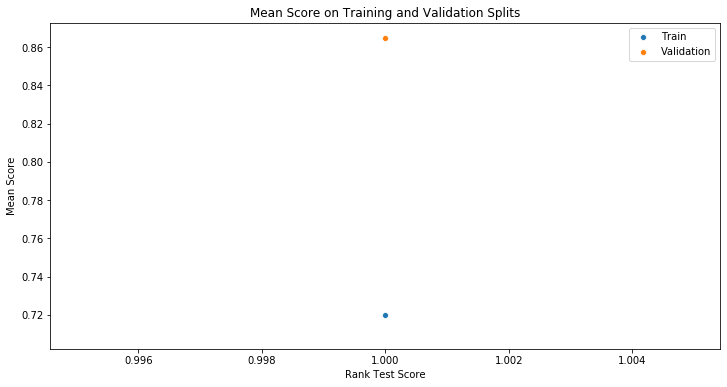

In [144]:
fig = plt.figure(figsize=(12,6))
fig = sns.scatterplot(x=df_cv_results_lgb['rank_test_score'],y=-df_cv_results_lgb['mean_train_score'],label='Train')
fig = sns.scatterplot(x=df_cv_results_lgb['rank_test_score'],y=-df_cv_results_lgb['mean_test_score'],label='Validation')
fig = plt.title('Mean Score on Training and Validation Splits')
fig = plt.ylabel('Mean Score')
fig = plt.xlabel('Rank Test Score')

### Test

In [145]:
preds_lgb = random_search_lgb_best.predict(df_train.loc[list_index[0][1]][feat_to_use])
np.sqrt(mean_squared_error(df_train.loc[list_index[0][1]][target_feat],preds_lgb))

0.8630178588388843

### Visualize

C:\Users\miguel.almas\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



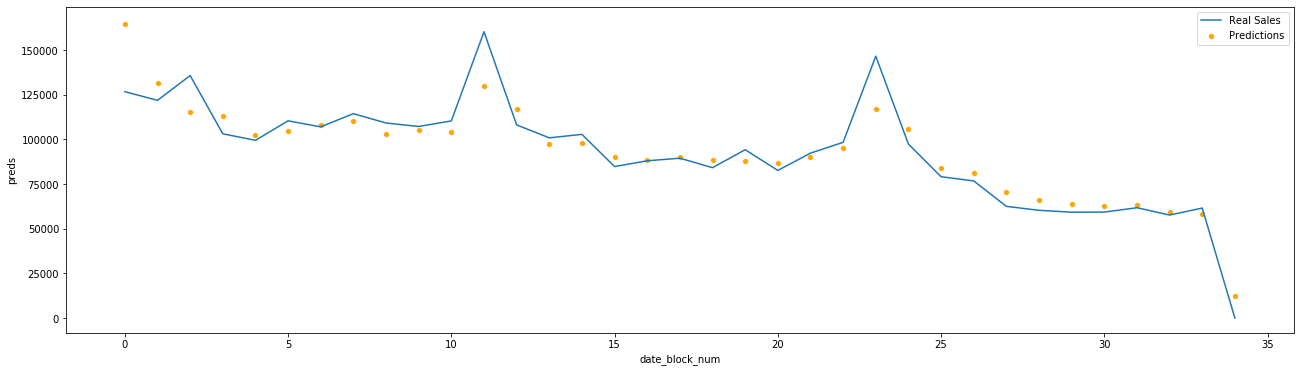

In [146]:
preds_lgb_all = random_search_lgb_best.predict(df_model[feat_to_use])
df_model['preds'] = preds_lgb_all

tmp = pd.DataFrame(df_model.groupby('date_block_num')['item_cnt_month','preds'].sum()).reset_index()

fig = plt.figure(figsize=(22,6))
fig = sns.lineplot(x='date_block_num',y='item_cnt_month',data=tmp,label='Real Sales')
fig = sns.scatterplot(x='date_block_num',y='preds',data=tmp,label='Predictions',c=['orange'])

# Produce Results

In [147]:
filt = df_test['ID'].isna() == False
preds_final = random_search_lgb_best.predict(df_test[filt][feat_to_use])
pred_final = preds_final.clip(0,20)
#preds_final['ID'] = preds_final['ID'].fillna(0)

In [148]:
df_preds_final =df_test[filt][['ID']]
df_preds_final['ID'] = df_preds_final['ID'].astype('int32')
df_preds_final['item_cnt_month'] = preds_final

In [149]:
df_preds_final[['ID','item_cnt_month']].to_csv('.\\data_files\\predictions.csv',index=False)